# GIS Programming and Databases
## Assignment 4

NAME: Grey Harris

ID: 97774899

Due: Friday, 3 June 2022, 10:05 PM

## Imports

In [4]:
import xarray as xr
import datetime
import numpy as np # you can use numpy functions with xarray objects
import salem # this will help with plotting/projection 
import cartopy.crs as ccrs # an alternative way to handle plotting/projection yourself
import matplotlib.pyplot as plt
from math import ceil
import fwi_nz as fwi_calc  # The fwi calculator, make sure to have fwi_nz.py in the same folder as this notebook
import numpy as np # you can use numpy functions with xarray objects
import glob # a library to handle path/folder/file related issues
from dask.diagnostics import ProgressBar
import geocoder
import time
import geopandas
import shapely
import envlib_helper as envlib
from tethysts import Tethys
import rioxarray
from shapely.geometry import mapping
from shapely import wkt
from dateutil.relativedelta import relativedelta
import math
import pickle

from sklearn_som.som import SOM
import pandas as pd
import cartopy.crs as ccrs
from tqdm import tqdm
from sklearn import preprocessing
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib
import itertools
from dask.diagnostics import ProgressBar

In [5]:
from pathlib import Path
user_home = str(Path.home())
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=1, memory_limit='30GB',local_directory=user_home)
client
tasks = [False, True]

distributed.diskutils - INFO - Found stale lock file and directory '/home/UOCNT/gha47/dask-worker-space/worker-vc8v0m1y', purging


#### In addition to your comprehensive answer to the three questions below you will be also marked based on the following criteria:
##### 1. Demonstrate the use of data chunking for optimizing the code
##### 2. Use geographic projections for producing maps
##### 3. Detailed code commenting to explain code block/function objectives
##### 4. Elaborate discussion of your results in form of comments along with the results. (especially this)
##### 5. A sound analytical methodology that is also discussed relevant to the objectives.
##### 6. The SOM algorithm requires tuning and optimization with respect to the learning rate, node number, and epoch values as shown in the lab. It is expected that you demonstrate in your notebook how you have done that and what supports your chosen settings to answer the questions.

# Question 1
#### Is there a regional preference for high Fire Weather Index in New Zealand and what can be driving this spatial variability? 
Hint: This is a two part question, so make sure you cover both. Please use the years 2015 to 2020 (so 5-years) to answer this question. To evaluate the meteorological drivers for FWI feel free to either use the meteorological parameters (like wind speed, temperature, etc …) or the indices that are calculated for the FWI, but explain your methodology and discuss the results. I am not expecting an essay, but merely a very pretty and comprehensive notebook.

### Functions used to solve Q1

In [6]:
def dataloader(dataname, chunks={"time":24,"height":1}):
    """
    loads five years data and pre processes them into chunks
    This uses chunking to demonstrate ability as per (1) in marking criteria, 
    It does however seem to make the kernel unstable compared to not using dask mf parellel datasets
    """
    five_years = ["2016", "2017", "2018", "2019", "2020"]
    files = [sorted(glob.glob(f"/mnt/data/FWI_WRF/{dataname}{year}*", recursive=False)) for year in five_years]
    merged = list(itertools.chain(*files))
    return xr.open_mfdataset(merged, chunks=chunks, parallel=True)

In [7]:
def calc_som(m, n, data, epoch=10, rate=0.5):
    """ 
    Slightly modified code from lab to allow learning rate and epochs to be modified from function call
    This makes running batches to test lr/epochs easier to automate
    """
    lat_dim = data.shape[1]
    lon_dim = data.shape[2]
    # Build a m x n SOM 
    som = SOM(m=m, n=n, dim=lat_dim*lon_dim, lr=rate)

    # Fit it to the data
    som.fit(data.reshape((data.shape[0],lat_dim*lon_dim)), epochs=epoch)

    # Assign each datapoint to its predicted cluster
    predictions = som.predict(data.reshape((data.shape[0],lat_dim*lon_dim)))
    return som, predictions

In [8]:
def generate_som_dict(FWI, predict_som, end=9):
    """
    Generates a dictionary of som buckets from a som prediction
    INPUT:
        FWI, fwi data array
        predict_som, prediction data from an sklearn SOM
    RETURN:
        dictionary of mean fwi's from SOM
    """
    som_dict = {}
    for i in range(0,end):
        mask = predict_som == i
        som_FWI = FWI[mask]
        mean_FWI = som_FWI.mean(dim="time")
        som_dict[str(i)]=mean_FWI.load()
    return som_dict

In [9]:
def gen_som_maps(FWI, som_dict, cmap="Reds", end=9, vmax=80):
    """
    Generates a dictionary of som buckets from a som prediction
    INPUT:
        FWI, fwi data array
        som_dict, dict of SOM map means
        end, int number of buckets. make sure its a square num logic wont work otherwise
    RETURN:
        void, displays map in notebook
    """
    proj = FWI.salem.cartopy()
    color_map = cmap
    fig = plt.figure(figsize=[16,12])
    root = int(math.sqrt(end))
    for i in range(0,end):
        ax = plt.subplot(root,root,i+1,projection=proj)
        som_dict[str(i)].plot(cmap=color_map, transform=proj, vmin=0, vmax=vmax, extend="both")
        ax.coastlines('10m', linewidth=1)
        ax.set_aspect('auto')
        ax.set_extent(FWI.salem.grid.extent, crs=proj)
        ax.gridlines(alpha=0.7)
        plt.tight_layout()
    #plt.savefig("som_4by4.pdf", dpi=60) 

In [10]:
def full_som_prediction(FWI_5_YEARS, end=9, lr=0.5, epochs=10, cmap="Reds", vmax=80):
    """
    Made as im lazy and dont want to call multiple fucntions to make a som
    
    INPUT:
        FWI, data
        end, int number of buckets. make sure its a square num logic wont work otherwise
        lr, float 0-1 to specify lerning rate
        epochs int, number of epochs for som
    RETURN:
        void, prints som to notebook
    """
    root = int(math.sqrt(end))
    FWI_5Y = FWI_5_YEARS.FWI
    time_5Y = FWI_5_YEARS.time
    ds_np_5Y = xr.DataArray.to_numpy(FWI_5Y.load())
    ds_np_nonan_5Y = np.nan_to_num(ds_np_5Y, nan = -9999) # water is all set to this to seperate it
    som, predict_som = calc_som(root, root, ds_np_nonan_5Y, epoch=epochs, rate=lr)
    SOM_5_YEAR_DICT = generate_som_dict(FWI_5Y, predict_som, end=end)
    gen_som_maps(FWI_5Y, SOM_5_YEAR_DICT, cmap=cmap, end=end, vmax=vmax)
    return som, predict_som
# full_som_prediction(FWI_5_YEARS, end=4, lr=0.2, epochs=20)

In [11]:
def mask_land(df):
    """creates a mask based on high soil moisture to mask non terestiral bodies"""
    smois_file = '/mnt/data/MetService_WRF/SMOIS_20000101000000.nc'
    chunks={"height":1,"time":100}
    ds_s = xr.open_dataset(smois_file,chunks=chunks)
    cond_mask=(ds_s.SMOIS[0,1,...]<0.8).compute()
    mask=(ds_s.SMOIS[0,1,...]<0.9)
    return df.where(mask)

In [12]:
def save_som_predictions(filename, som):
    """saves som predictions np pickle (Stops me rerunning when kernel crashes)"""
    np.save(filename, som)

def open_som_predictions(filename):
    """load som predictions for np"""
    return np.load(filename)

def save_som_pkl(filename, som):
    """open pickled som and attach to som"""
    with open(filename + ".pkl", 'wb') as file:
        pickle.dump(som, file)

def open_som_pkl(filename):
    """Opens file bytes then loads pickle"""
    return pickle.load(open(filename, 'rb'))

In [13]:
def make_salem(data, title='Temp (*C)'):
    # inspiration taken from https://salem.readthedocs.io/en/v0.2.3/auto_examples/plot_change_style.html#sphx-glr-auto-examples-plot-change-style-py
    # and https://salem.readthedocs.io/en/v0.2.3/auto_examples/plot_subgrid_mask.html
    masked = mask_land(data)
    
    smap = masked.T.salem.get_map(countries=False)
    f, ax = plt.subplots(figsize=(10,40))
    ax2 = masked.T.salem.quick_map()
    # Change the country borders
    smap.set_shapefile(countries=True)
    
    # Add water bodies
    smap.set_shapefile(rivers=True)
    smap.set_shapefile(lakes=True, facecolor='grey')

    smap.set_scale_bar(location=(0.87, 0.1), add_bbox=True)

    #plt.figure(dpi=200)
    smap.visualize(ax=ax, title=f'New Zealand Median {title}')
    plt.show()


#make_salem(ds_t_land, title="ADD TITLE HERE")

### Collect 5 year data

In [14]:
chunks={"time":24,"height":1}

In [15]:
dataname = "FWI_"
FWI_5_YEARS = dataloader(dataname, chunks={"time":24,"height":1})

In [16]:
FWI_5_YEARS # having a peek to see what I got

<xarray.Dataset>
Dimensions:  (time: 1828, lat: 508, lon: 472)
Coordinates:
  * time     (time) datetime64[ns] 2015-12-31 2016-01-01 ... 2020-12-31
  * lat      (lat) float64 -48.0 -47.97 -47.94 -47.92 ... -34.06 -34.03 -34.01
  * lon      (lon) float64 166.0 166.0 166.1 166.1 ... 178.9 178.9 179.0 179.0
Data variables:
    FFMC     (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    DMC      (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    DC       (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    ISI      (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    BUI      (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    FWI      (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>

In [17]:
# I did not bother making this a function as it is only completed once
FWI_5Y = FWI_5_YEARS.FWI
time_5Y = FWI_5_YEARS.time
ds_np_5Y = xr.DataArray.to_numpy(FWI_5Y.load())
ds_np_nonan_5Y = np.nan_to_num(ds_np_5Y, nan = -9999) # water is all set to this to seperate it

### Just trying a single year to see how lr/epochs interact when changed

In [18]:
# load files
FWI_files=sorted(glob.glob('/mnt/data/FWI_WRF/*', recursive=True)) 
ds = xr.open_dataset("/mnt/data/FWI_WRF/FWI_2020.nc")

In [14]:
FWI = ds.FWI
time = ds.time
ds_np=xr.DataArray.to_numpy(FWI.load())
ds_np_nonan = np.nan_to_num(ds_np, nan = -9999) # water is all set to this to seperate it

### 10 epochs in 19 mins

In [15]:
%%time
som, predict_som = calc_som(3,3, ds_np_nonan, epoch=10, rate=0.5)

CPU times: user 8min 52s, sys: 1min 9s, total: 10min 2s
Wall time: 9min 50s


### 40 epochs in 12 mins
##### I find this really confusing, 40 epochs should take 4 times as long as 10 epochs so not sure how it is faster when eva said there is no early stopping

In [16]:
%%time
som, predict_som = calc_som(3,3, ds_np_nonan, epoch=40, rate=0.5)

CPU times: user 9min 25s, sys: 1min 33s, total: 10min 58s
Wall time: 10min 46s


.

Moving on to actual question now

### Trying 10 epochs 0.5 lr for 5 Year period

In [ ]:
# %%time
# som, predict_som = calc_som(3,3, ds_np_nonan_5Y, epoch=10, rate=0.5)
# SOM_5_YEAR_DICT = generate_som_dict(FWI_5Y, predict_som, end=9)
# gen_som_maps(FWI_5Y, SOM_5_YEAR_DICT)

In [15]:
%%time
som, predict_som = calc_som(3,3, ds_np_nonan_5Y, epoch=10, rate=0.5)

CPU times: user 13min 43s, sys: 3min 14s, total: 16min 57s
Wall time: 16min 21s


In [16]:
SOM_5_YEAR_DICT = generate_som_dict(FWI_5Y, predict_som, end=9)

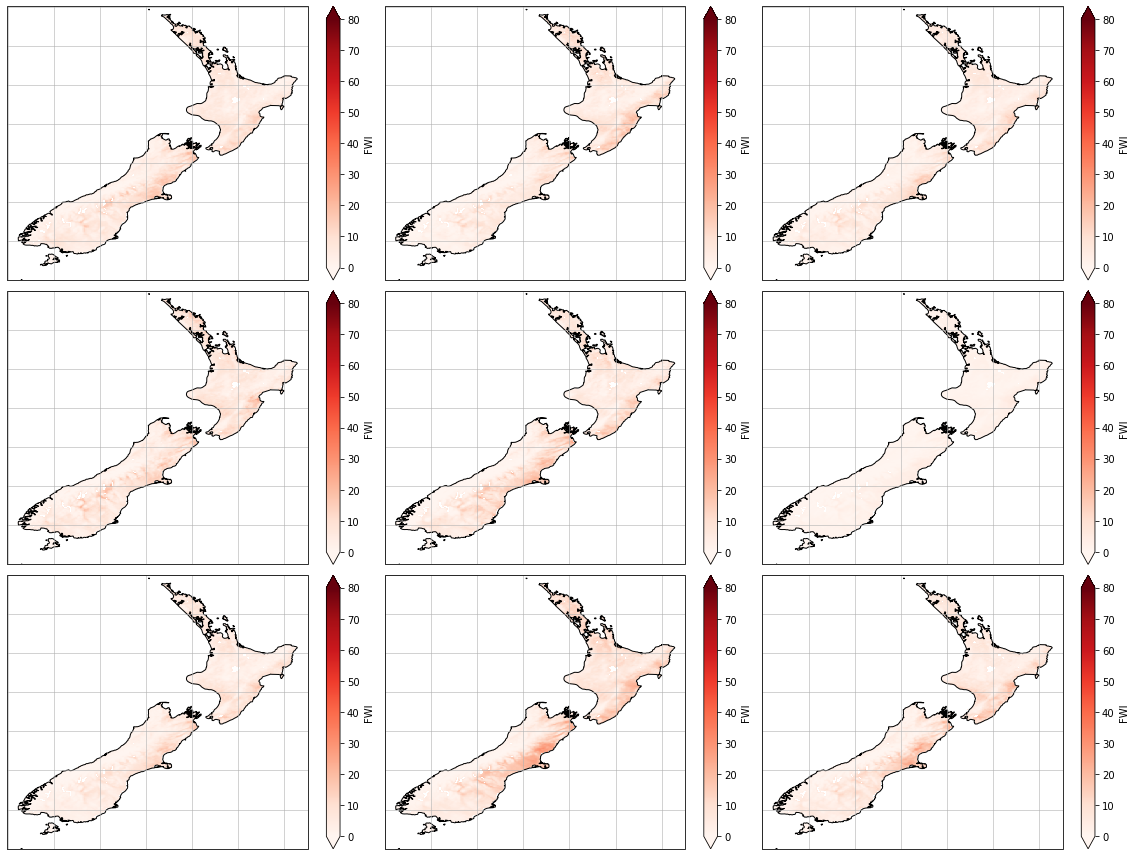

In [17]:
gen_som_maps(FWI_5Y, SOM_5_YEAR_DICT)

##### Lowered learning rate a bit (changing it dones not really matter if reading the library the skitlearn model is made from it adjusts it over time anyways)
##### Also trying more epocs, The time taken can vary a bit as the initial start points seem to speed up the convergence at random so it stops early when nodes not being moved around????

In [14]:
%%time
som, predict_som = calc_som(3,3, ds_np_nonan_5Y, epoch=10, rate=0.5)
SOM_5_YEAR_DICT = generate_som_dict(FWI_5Y, predict_som, end=9)

CPU times: user 10min 27s, sys: 1min 43s, total: 12min 10s
Wall time: 12min 1s


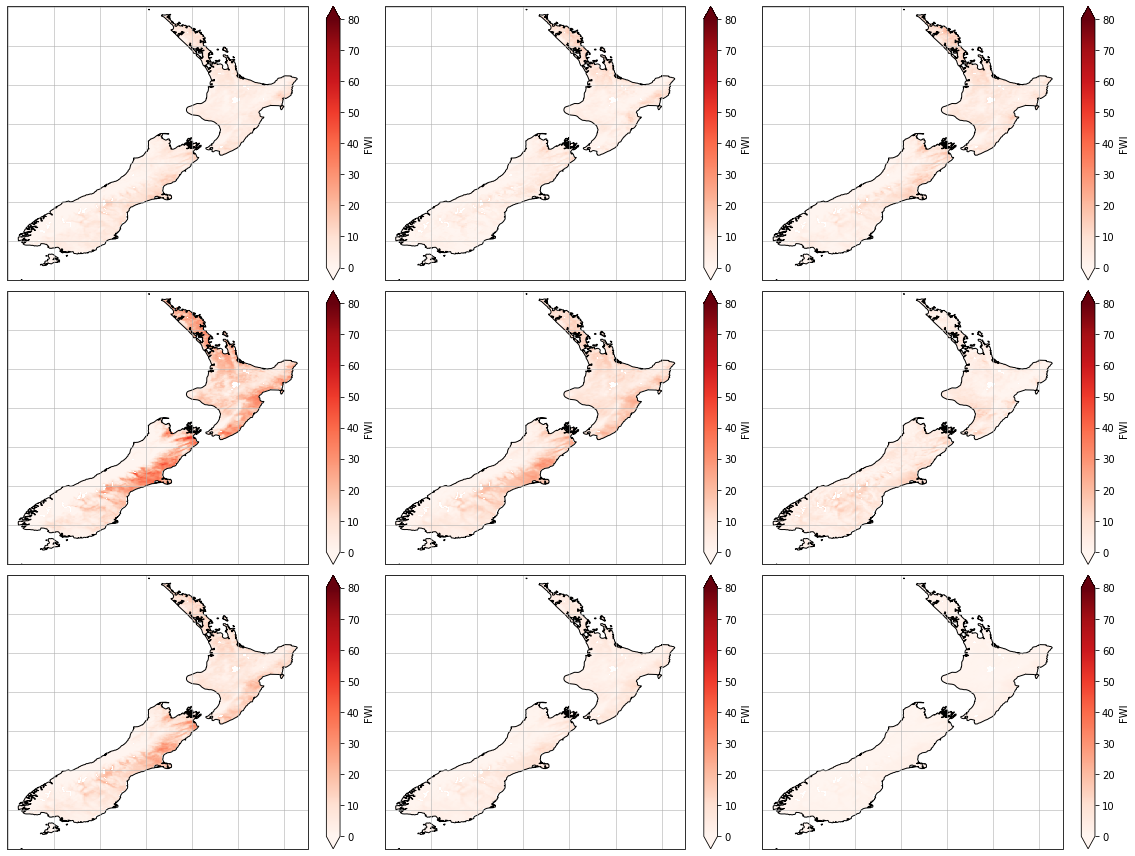

In [15]:
gen_som_maps(FWI_5Y, SOM_5_YEAR_DICT)  # maps for more epochs same learning rate

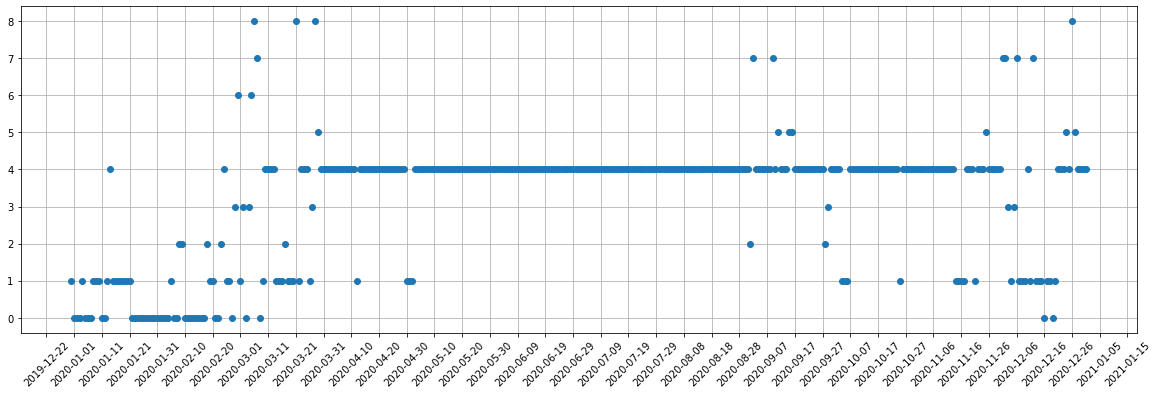

In [14]:
plt.figure(figsize=(20, 6))
plt.plot(time,predict_som, "o")
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.xticks(rotation=45);

#### The Graph above shows that mucch of the data from winter months is captured in cluster 4
#### This makes sense as the FWI values are low during the wets season. most vartiation that needs to be explained is in the dry summer season

In [ ]:
%%time
som, predict_som = calc_som(3,4, ds_np_nonan_5Y, epoch=50, rate=0.2)
SOM_5_YEAR_DICT = generate_som_dict(FWI_5Y, predict_som, end=9)
#gen_som_maps(FWI_5Y, SOM_5_YEAR_DICT, cmap="nipy_spectral", end=9, vmax=30)

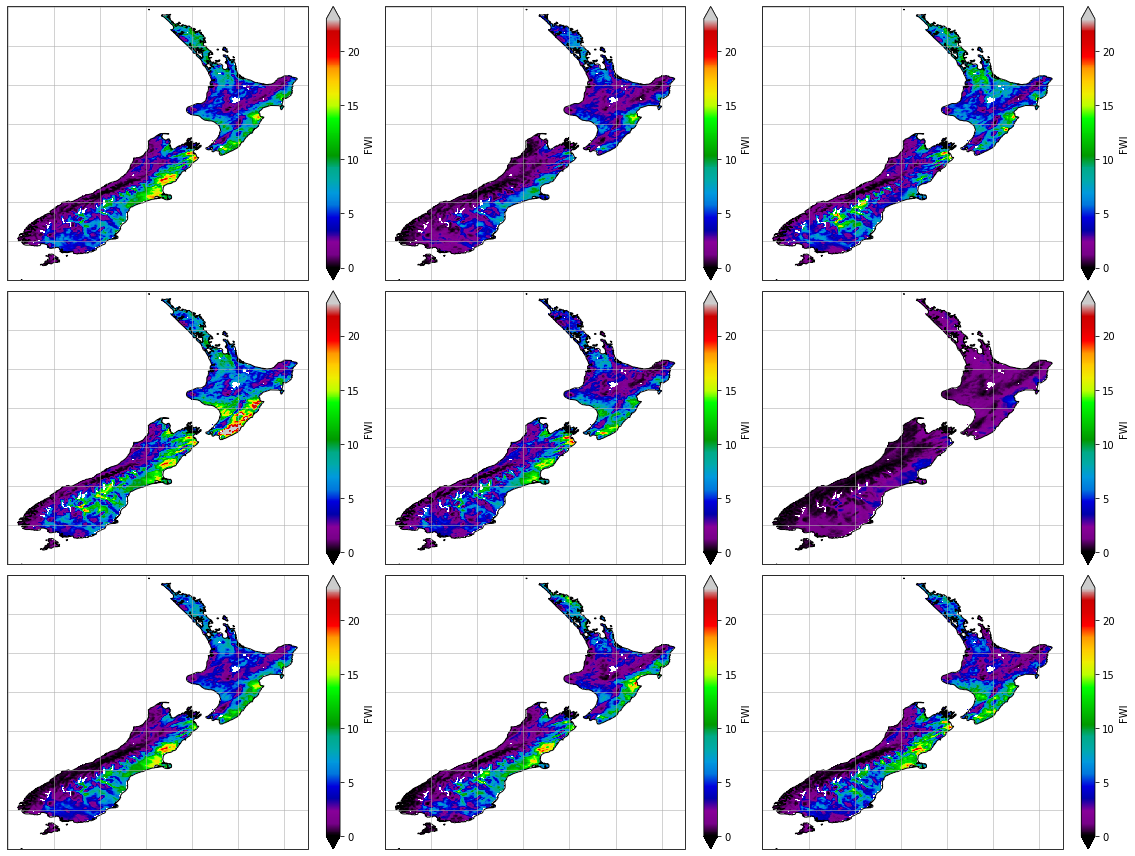

In [20]:
gen_som_maps(FWI_5Y, SOM_5_YEAR_DICT, cmap="nipy_spectral", end=9, vmax=23)

In [ ]:
# %%time
# som, predict_som = full_som_prediction(FWI_5_YEARS, end=9, lr=0.4, epochs=20, cmap="nipy_spectral_r")
# save_som_predictions("FWI5Y_end9_lr4_e20", som)
# save_som_pkl("FWI5Y_end9_lr4_e20", predict_som)

### The above clustering shows areas with high FWI clusters, however many of the buckets are very similar so I will try again with a lower number of buckets

### Note that the center graph has alot of similarity to average wind speed minus high rainfall shown later in this setion

In [ ]:
# som, predict_som = full_som_prediction(FWI_5_YEARS, end=4, lr=0.2, epochs=20)

In [12]:
%%time
som, predict_som = calc_som(2,2, ds_np_nonan_5Y, epoch=10, rate=0.5)
SOM_5_YEAR_DICT = generate_som_dict(FWI_5Y, predict_som, end=4)

CPU times: user 10min 40s, sys: 2min 16s, total: 12min 56s
Wall time: 12min 58s


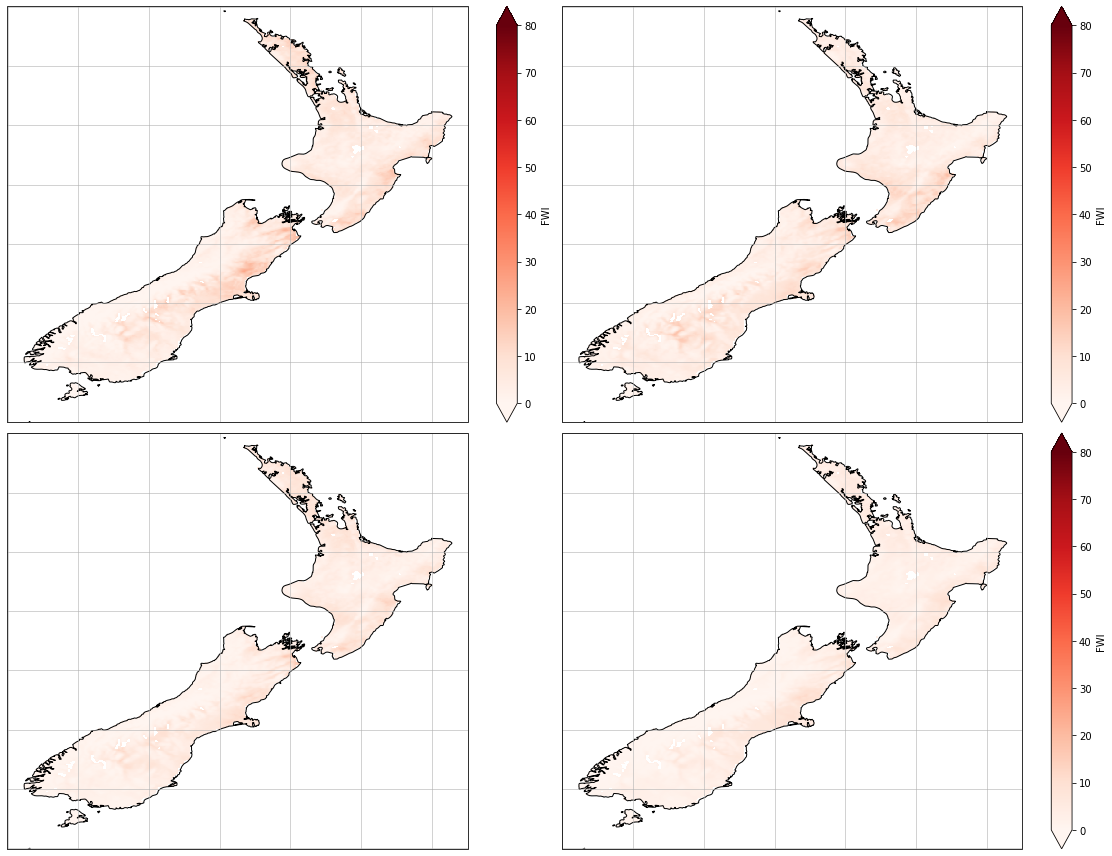

In [14]:
gen_som_maps(FWI_5Y, SOM_5_YEAR_DICT, end=4)

In [17]:
save_som_predictions("FWI5Y_end4_lr5_e10", som)
save_som_pkl("FWI5Y_end4_lr5_e10", predict_som)

In [18]:
%%time
som, predict_som = calc_som(2,2, ds_np_nonan_5Y, epoch=20, rate=0.3)
SOM_5_YEAR_DICT = generate_som_dict(FWI_5Y, predict_som, end=4)
save_som_predictions("FWI5Y_end4_lr3_e20", som)
save_som_pkl("FWI5Y_end4_lr3_e20", predict_som)

CPU times: user 8min 24s, sys: 1min 19s, total: 9min 44s
Wall time: 9min 45s


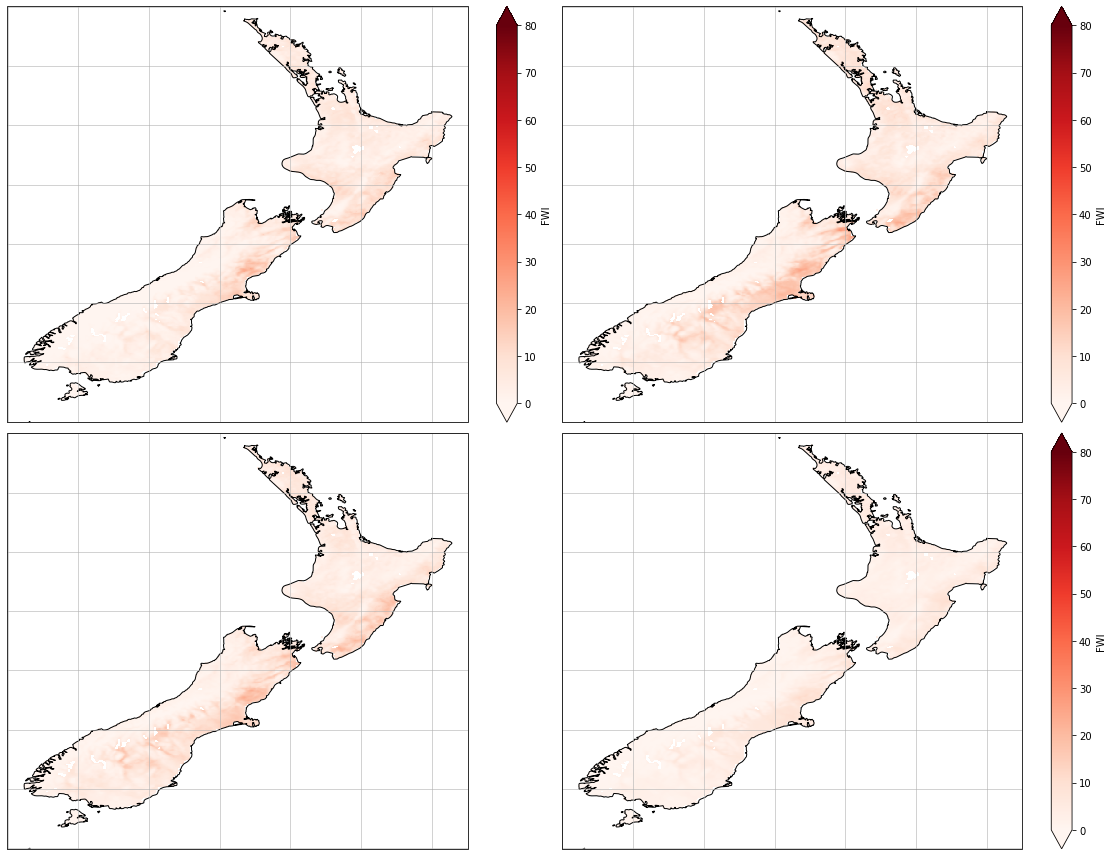

In [19]:
gen_som_maps(FWI_5Y, SOM_5_YEAR_DICT, end=4)

### The grpahs above with only 4 buckets better show areas where there is high FWI risk than with 9 buckets

In [20]:
%%time
som, predict_som = calc_som(2,2, ds_np_nonan_5Y, epoch=50, rate=0.2)
SOM_5_YEAR_DICT = generate_som_dict(FWI_5Y, predict_som, end=4)
save_som_predictions("FWI5Y_end4_lr2_e50", som)
save_som_pkl("FWI5Y_end4_lr3 2_e50", predict_som)

CPU times: user 7min 43s, sys: 35.8 s, total: 8min 19s
Wall time: 8min 20s


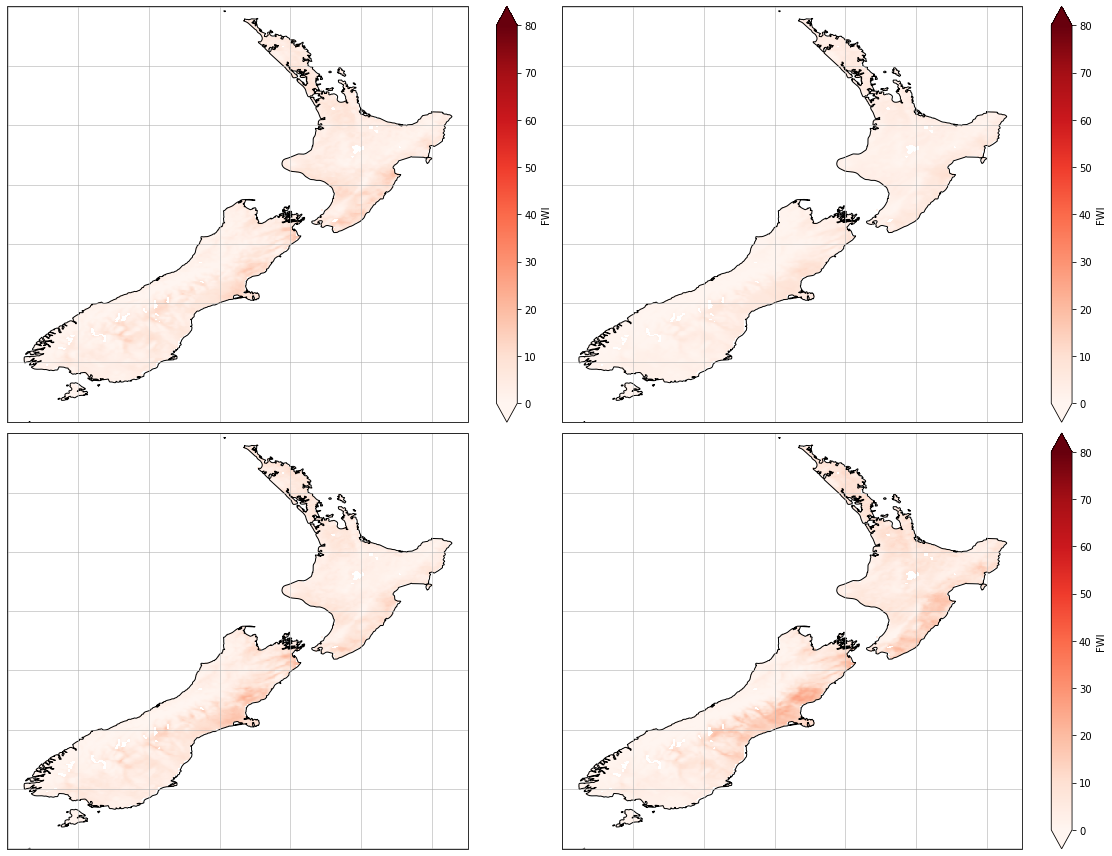

In [21]:
gen_som_maps(FWI_5Y, SOM_5_YEAR_DICT, end=4)

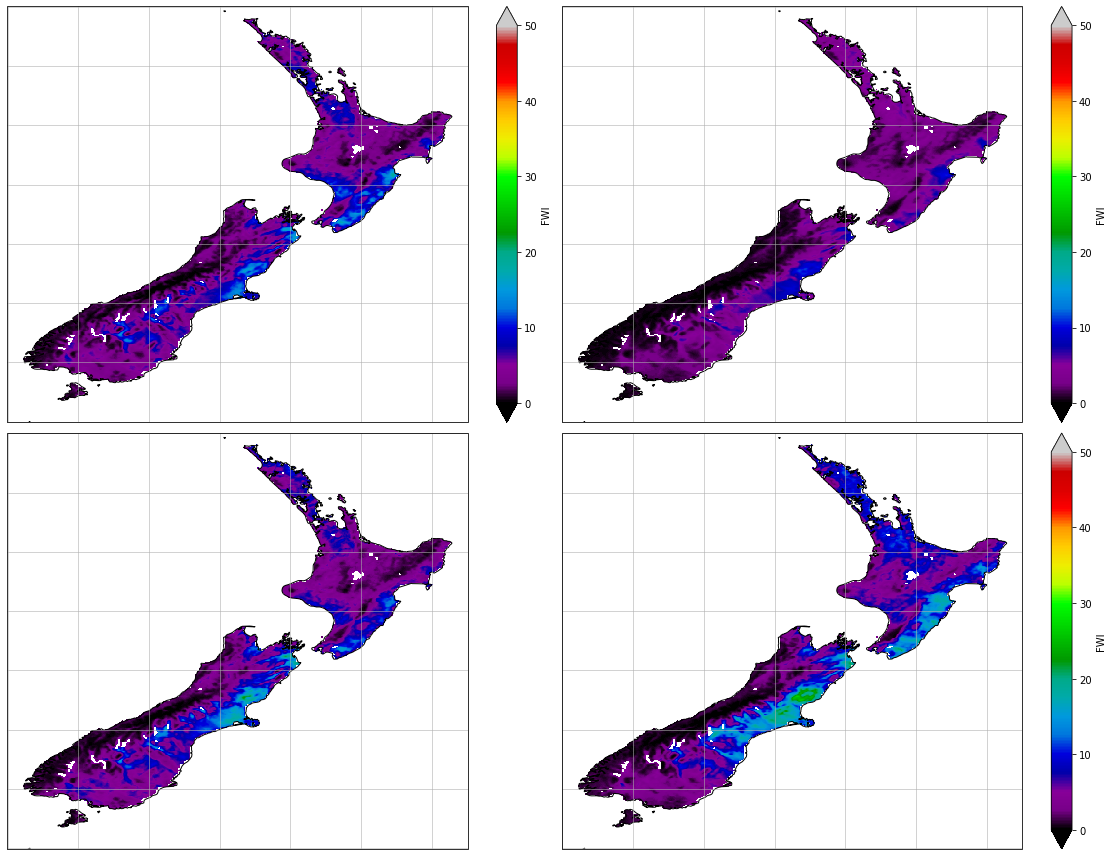

In [22]:
gen_som_maps(FWI_5Y, SOM_5_YEAR_DICT, cmap="nipy_spectral", end=4, vmax=50)

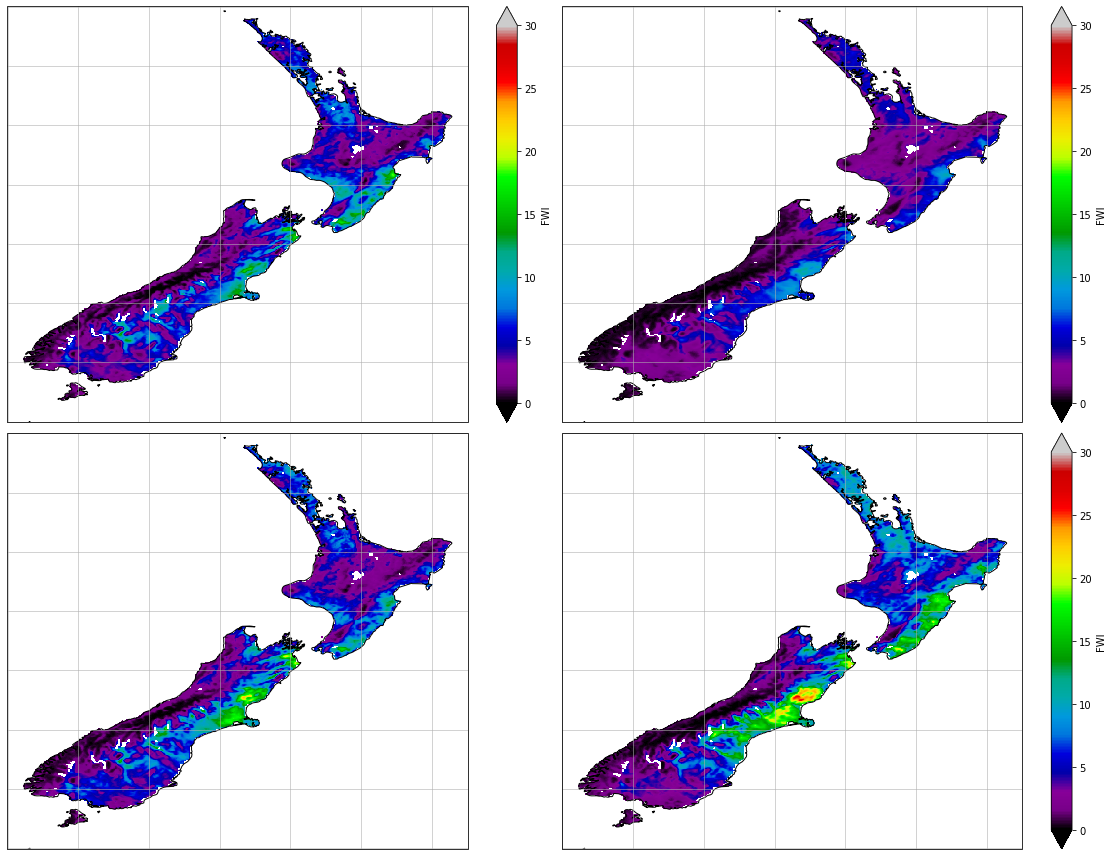

In [23]:
gen_som_maps(FWI_5Y, SOM_5_YEAR_DICT, cmap="nipy_spectral", end=4, vmax=30)

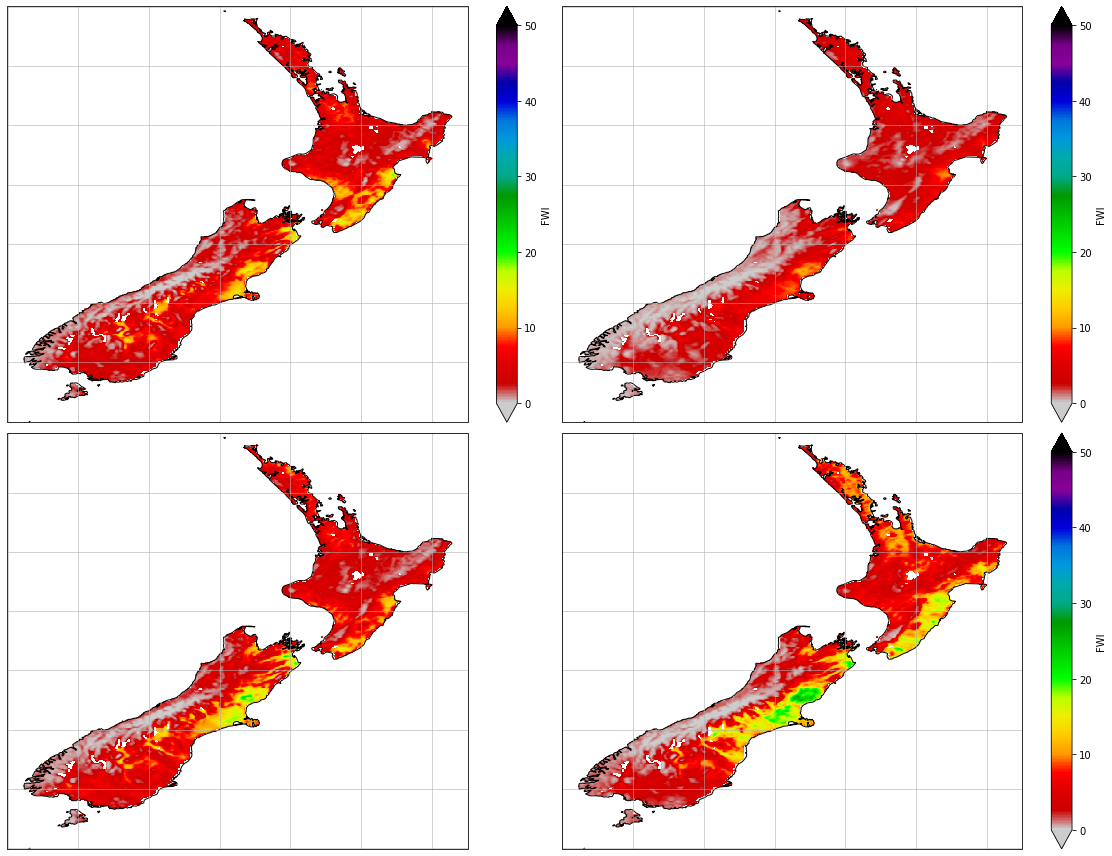

In [24]:
gen_som_maps(FWI_5Y, SOM_5_YEAR_DICT, cmap="nipy_spectral_r", end=4, vmax=50)

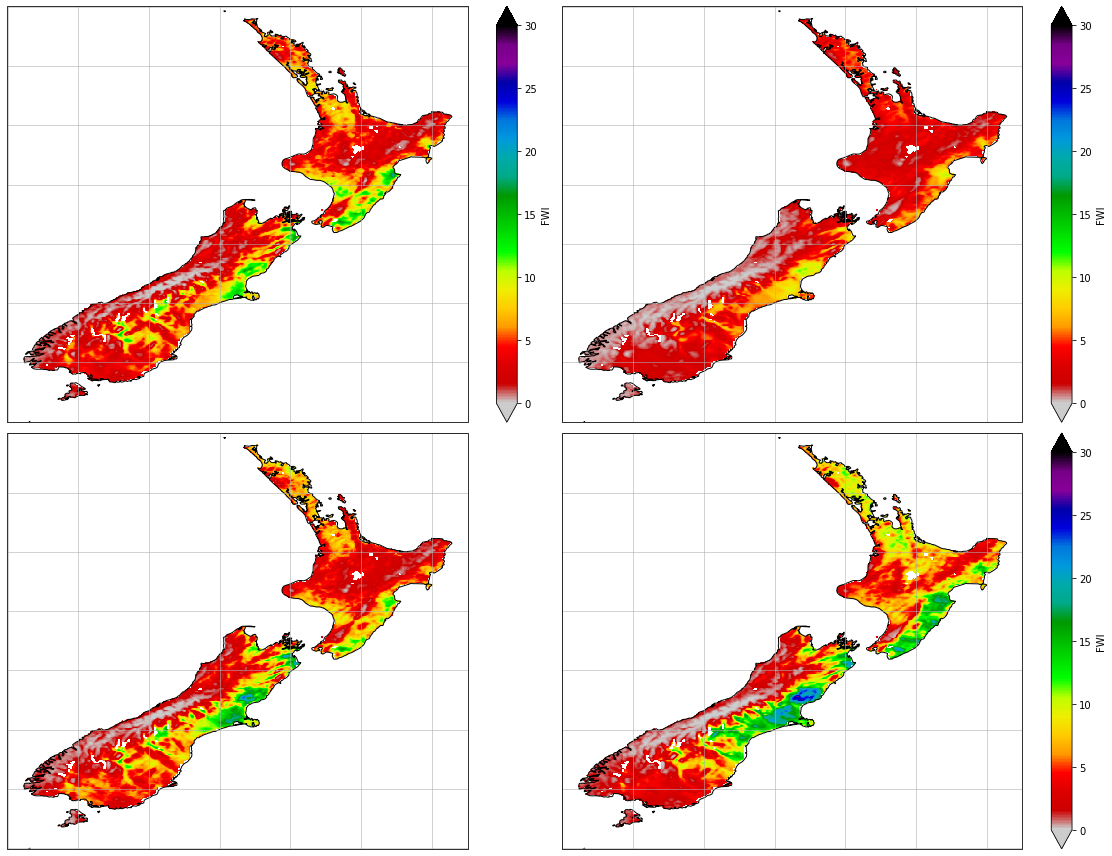

In [25]:
gen_som_maps(FWI_5Y, SOM_5_YEAR_DICT, cmap="nipy_spectral_r", end=4, vmax=30)

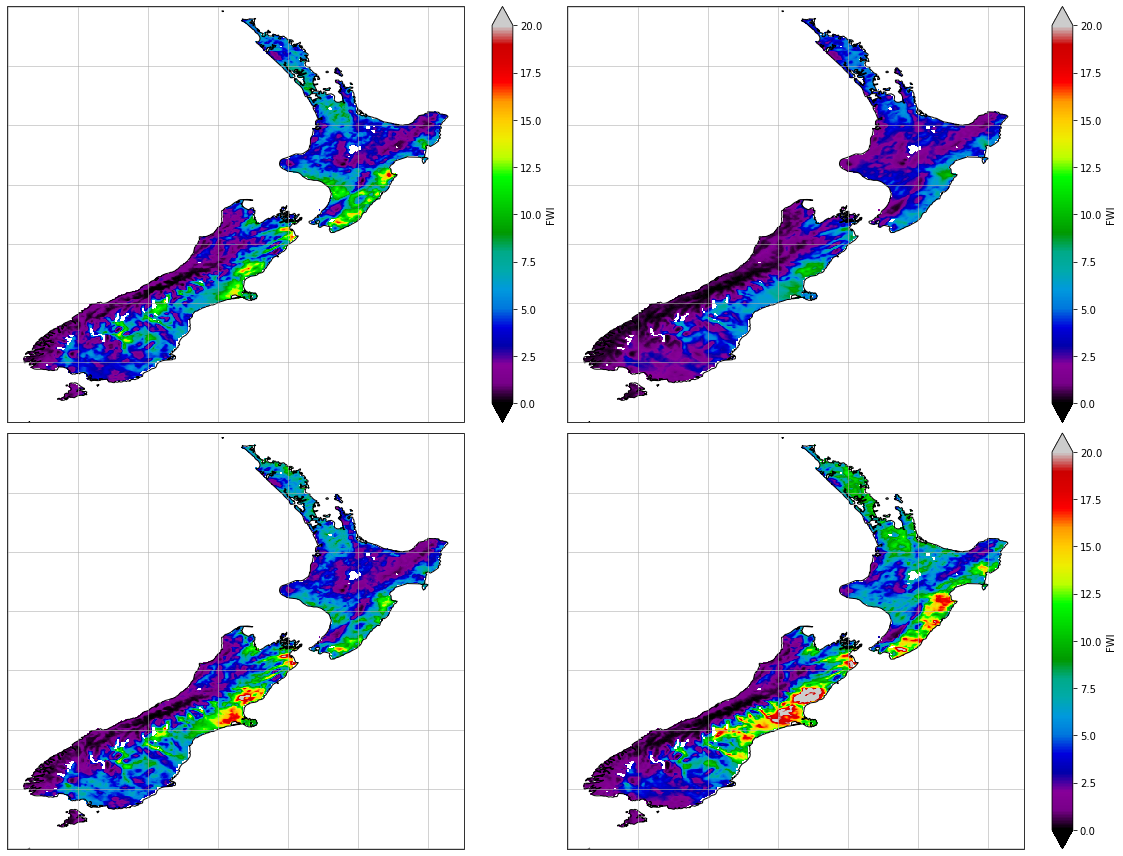

In [26]:
gen_som_maps(FWI_5Y, SOM_5_YEAR_DICT, cmap="nipy_spectral", end=4, vmax=20)

### The Final two sets of maps were the best colour mappings I could manage for the epoch=50, rate=0.2 four bucket som
#### Setting the vmax to around 20 really highlights the clusters that were grouped around higher FWI scores (pity the top end is grey not red)

### Map below displays areas with extreme fire risk days as a heat map
##### Graphs from here on in Q1 are looking for things that explain the SOM FWO clusters

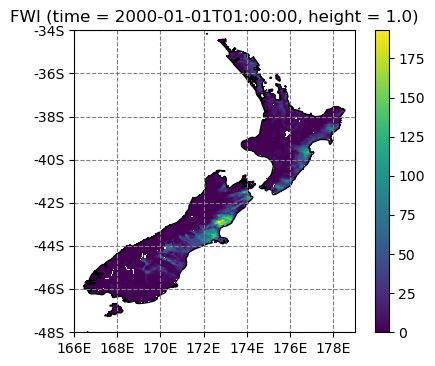

In [13]:
extreme_fwi_days = (FWI_5_YEARS.FWI >= 31).sum(axis=0) # days with at or over 31 in fwi rating
masked = mask_land(extreme_fwi_days)
plt.figure(dpi=100)
masked.salem.quick_map()

### The graph below displays areas of new zealand that have high maximum wind speeds, this would indicate that these areas are at higher fire risk due to the drying effect of wind/risk of fire spreading

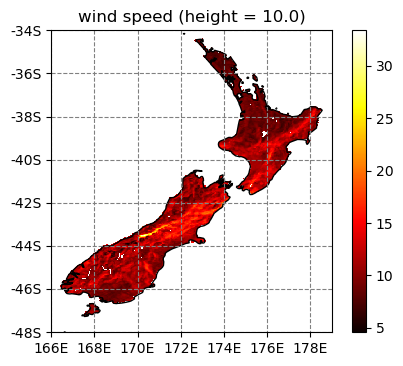

In [23]:
u_file='/mnt/data/MetService_WRF/U_20000101000000.nc'
v_file='/mnt/data/MetService_WRF/V_20000101000000.nc'
t_file = '/mnt/data/MetService_WRF/T_20000101000000.nc'
smois_file = '/mnt/data/MetService_WRF/SMOIS_20000101000000.nc'

chunks={"height":1,"time":100}

def calculate_ws_wd(u,v):
    wspeed = xr.ufuncs.sqrt(u*u + v * v)
    wdir   = (270-xr.ufuncs.arctan2(v,u)* 180/ np.pi)%360
    wspeed.name = "wind speed"
    wdir.name = "wind dir"
    wspeed.attrs["units"] = "m/s"
    return wspeed, wdir

ds_u = xr.open_dataset(u_file,chunks=chunks)
ds_v = xr.open_dataset(v_file,chunks=chunks)
ds_t = xr.open_dataset(t_file,chunks=chunks)
ds_s = xr.open_dataset(smois_file,chunks=chunks)

wind, _ = calculate_ws_wd(ds_u.U,ds_v.V)
land_only_max_wind = mask_land(wind).isel(height=0).max(dim="time")
plt.figure(dpi=100)
land_only_max_wind.salem.quick_map(cmap="hot")

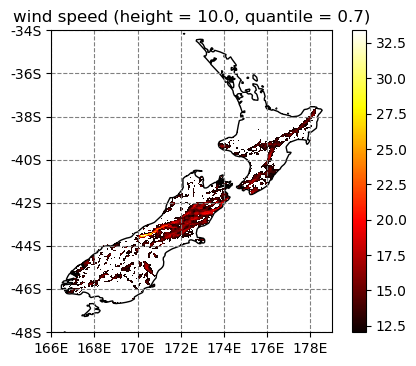

In [13]:
wind, _ = calculate_ws_wd(ds_u.U,ds_v.V)
plt.figure(dpi=100)
land_mask=(ds_s.SMOIS[0,1,...]<0.6).compute()
land_only=wind.where(land_mask)
land_only_max_wind=land_only.isel(height=0).max(dim="time")
land_only_max_wind.where(land_only_max_wind>land_only_max_wind.quantile(0.7)).salem.quick_map(cmap="hot")

### Above map shows the upper quantiles of wind in new zealand
##### Note it is mainly present in the plains and lower north island
##### There is an extreme high along the alps as well, this does not overly effect the areas fwi though

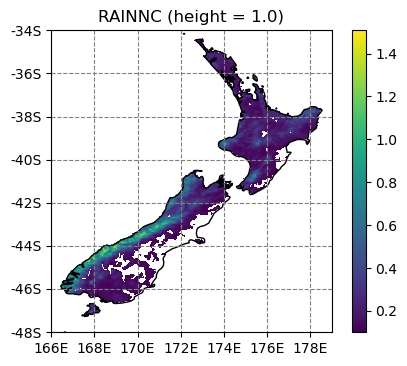

In [24]:
ds_rain = xr.open_mfdataset('/mnt/data/MetService_WRF/RAINNC_2016*',chunks=chunks)
plt.figure(dpi=100)
land_mask=(ds_s.SMOIS[0,1,...]<0.8).compute()
land_only_rain=ds_rain.where(land_mask)
land_only_avg_rain=land_only_rain.mean(dim="time")
land_only_avg_rain.RAINNC.where(land_only_avg_rain.RAINNC>0.1).salem.quick_map()

#### Graph above shows areas with higher average rainfall. The uncoloured areas have low rainvalls less than 0.1 on average. This Confirms that one of the reasosn the plains were clustered in SOM as high FWI as these areas low rainfalls increase the FWO score in the area

##### These final grpahs of low rainfall high average winds and temperatures togther explain much of the FWI's The major clusters are all differentiating these regtions seperatiing the inside with high fwi, the outside with low fwi

# Question 2
#### The summertime is usually New Zealand’s fire weatherseason. Where are the regions that exhibit more extreme fire weather during the summers between the year 2015 to 2020?


assign3 task 2 has glob and distributed stuff

Need to make own summer time som's here

For those who missed it please take note:

Question 2 for Assignment 4 asks about summertime spatial variability. You are required to develop a new SOM for the summertime periods only, and NOT discuss the SOM you produced for Q1. So you have to extract the summer time data of FWI (December to February inclusive) and produce a new SOM.

In [40]:
## The seasons in New Zealand
# Spring – September to November.
# Summer – December to February.   ### 1,2,12
# Autumn – March to May.
# Winter – June to August.

In [28]:
# Was surprised this did not work,. could not use hash when filtering
# def filter_summer(month):
#     """simple filter to extract dec, jan, feb months"""
#     return (True if month in [1,2,12] else False)

# print(filter_summer(1))
# print(filter_summer(3))

def filter_summer(month):
    """simple filter to extract dec, jan, feb months"""
    return ((month == 1)  | (month == 2) | (month == 12))

In [29]:
summer_df = ds.FWI.sel(time=filter_summer(ds.FWI['time.month']))
summer_df #display to see only expected months

<xarray.DataArray 'FWI' (time: 92, lat: 508, lon: 472)>
[22059392 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2019-12-31 2020-01-01 ... 2020-12-31
  * lat      (lat) float64 -48.0 -47.97 -47.94 -47.92 ... -34.06 -34.03 -34.01
  * lon      (lon) float64 166.0 166.0 166.1 166.1 ... 178.9 178.9 179.0 179.0

In [30]:
FWI = summer_df
#time = ds.time
ds_np=xr.DataArray.to_numpy(FWI.load())
ds_np_nonan = np.nan_to_num(ds_np, nan = -9999) # water is all set to this to seperate it

In [33]:
%%time
som, predict_som = calc_som(2,2, ds_np_nonan, epoch=20, rate=0.2)
SOM_SUM_DICT = generate_som_dict(FWI, predict_som, end=4)
save_som_predictions("FWISUM_end4_lr2_e20", som)
save_som_pkl("FWISUM_end4_lr2_e20", predict_som)

CPU times: user 5min 2s, sys: 15.4 s, total: 5min 18s
Wall time: 5min 15s


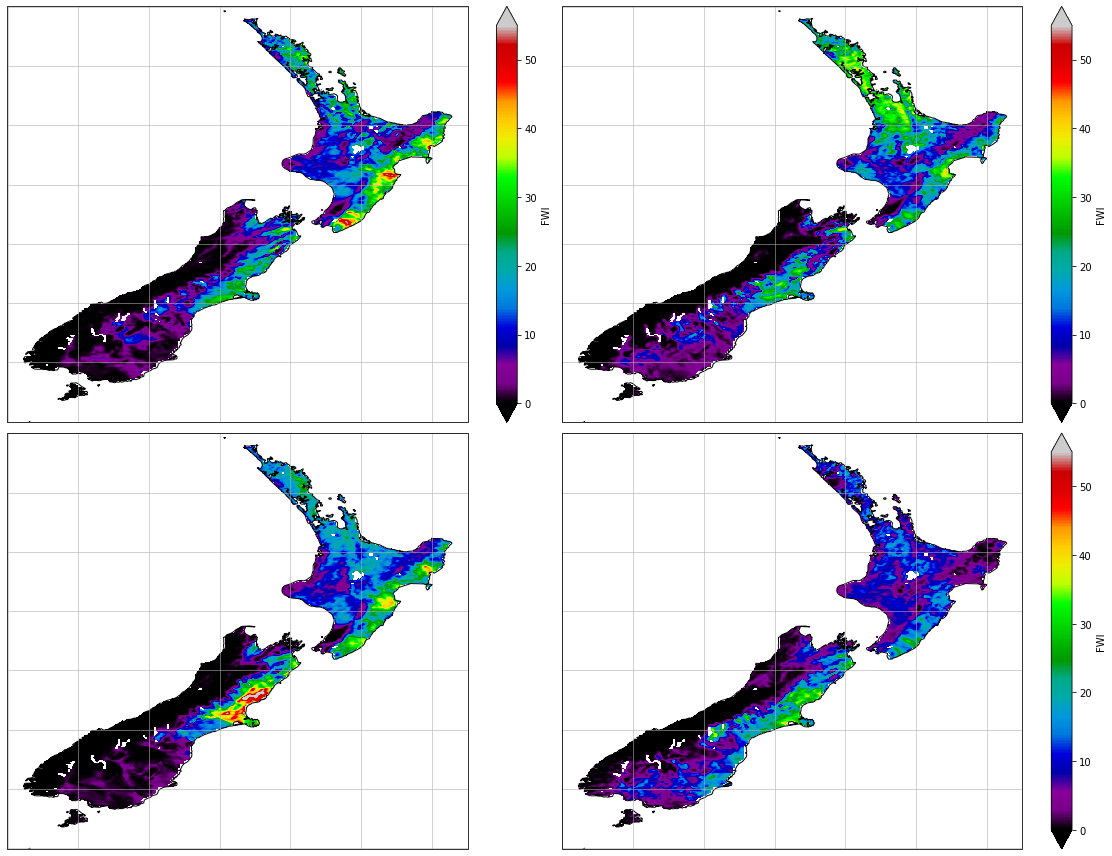

In [41]:
gen_som_maps(FWI, SOM_SUM_DICT, cmap="nipy_spectral", end=4, vmax=55)

In [35]:
%%time
som, predict_som = calc_som(3,3, ds_np_nonan, epoch=20, rate=0.2)
SOM_SUM_DICT = generate_som_dict(FWI, predict_som, end=9)
save_som_predictions("FWISUM_end9_lr2_e20", som)
save_som_pkl("FWISUM_end9_lr2_e20", predict_som)

CPU times: user 5min 22s, sys: 24.9 s, total: 5min 47s
Wall time: 5min 44s


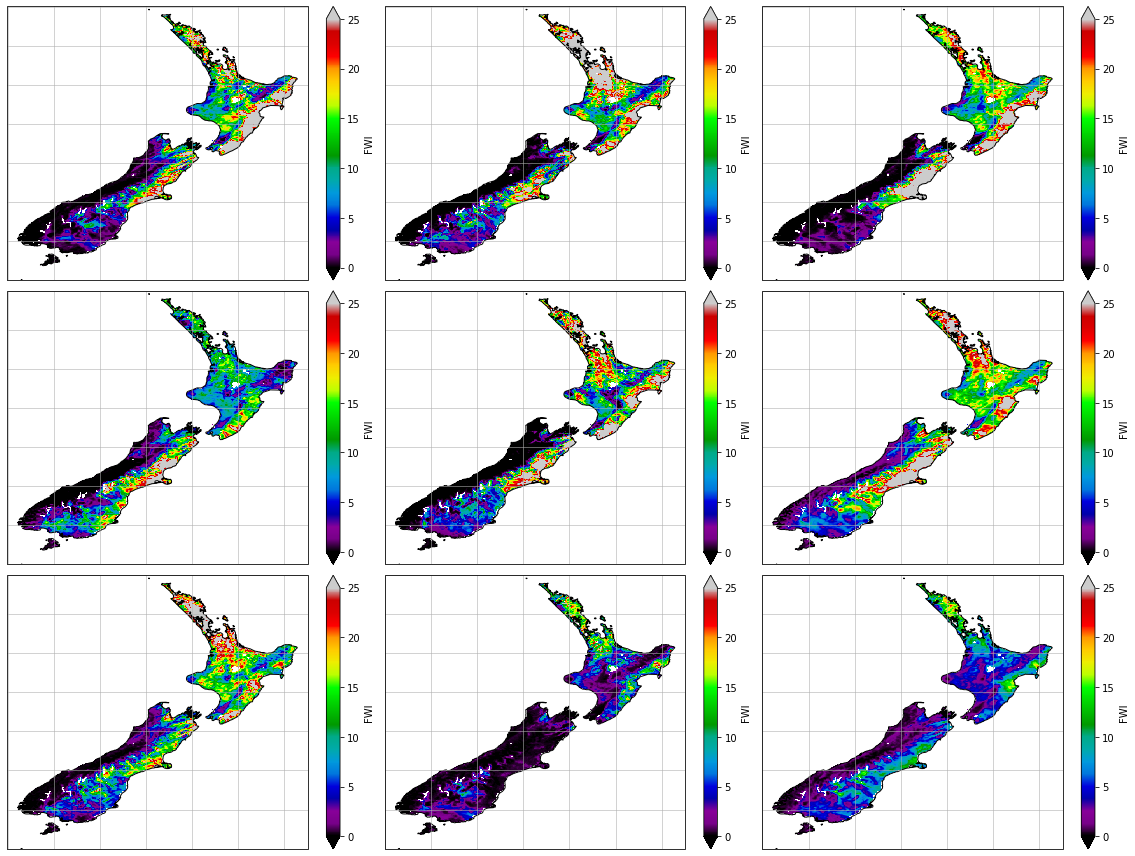

In [36]:
gen_som_maps(FWI, SOM_SUM_DICT, cmap="nipy_spectral", end=9, vmax=25)

Bellow is a heat map of summer months with high FWI days over 30 FWI

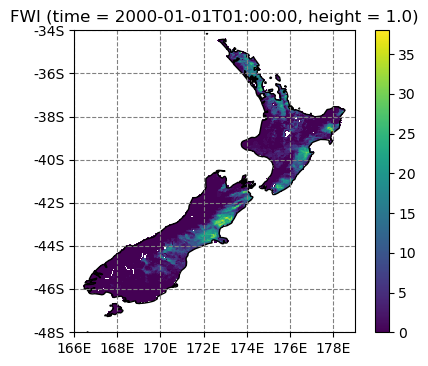

In [43]:
extreme_fwi_days = (FWI >= 31).sum(axis=0) # days with at or over 31 in fwi rating
masked = mask_land(extreme_fwi_days)
plt.figure(dpi=100)
masked.salem.quick_map()

#### The above graphs are SOM maps generated from the summer months, Dec/Jan/Feb. These have a better distribution of fwo areas than the original question 1 maps. This is because the areas fwi's are having more influence compared to the seasons weather paterns being the main clustering factor.

#### unlike in Q1 I think the nine buckets was better this time, there was a better split between them.

#### The main areas of interest are canterbury and the north island again. This is due to those areas having more wind and hihger temperatures. Rainfall does not have as large and influcnce in these areas however it still greatly influences the FWO in the west cost of the sound island.




### Main regions with high FWI are as follows,
#### Upper noth island around auckland and Whangarei
#### The gisbourne area
#### The south east coast of the north island especially around Napier nad Msterton.
#### Muuch of the canterbury plains.
#### 
#### 

Text(0.5, 1.0, 'FWI by month 2000-2020 Thresholded over 17')

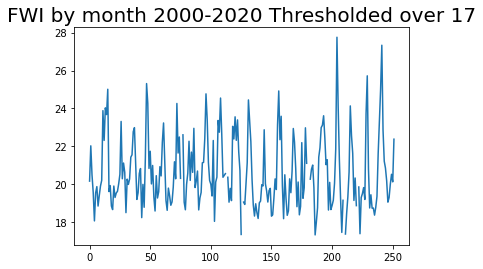

In [25]:
f, ax = plt.subplots()
fs = 20
plt.plot(fwi_months_17)
plt.title(label="FWI by month 2000-2020 Thresholded over 17",fontsize=fs)

#### The reason for this is partially explained by the graph above. The spikes in high fwi correspond with summers 

## Question 3
#### Redo question 1 but by only choosing the South Island as the input for your SOM algorithm.
Hint: This is a two part question, so make sure you cover both. Please use the years 2015 to 2020 (so 5-years) to answer this question. To evaluate the meteorological drivers for FWI feel free to either use the meteorological parameters (like wind speed, temperature, etc …) or the indices that are calculated for the FWI, but explain your methodology and discuss the results. I am not expecting an essay, but merely a very pretty and comprehensive notebook.

### I shared the below code with a couple people in class

In [72]:
def south_island(df):
    """
    created custom polygon file, "polygon.csv"
    to create a mask around south island region
    I sent a working sample xml to lecturer to view to see how it works :)
    """
    all_regions = geopandas.read_file("polygon.csv")
    all_regions.crs = "EPSG:4326"
    geometry = all_regions["WKT"].loc[all_regions.index[0]] # if you add more polys just change the index here to the correct place
    canty_poly = shapely.wkt.loads(geometry)
    canty_poly2 = geopandas.GeoSeries(canty_poly)
    canty_poly2.crs = "EPSG:4326"
    df = df.rio.write_crs("EPSG:4326")
    df = df.rio.set_spatial_dims("lon", "lat")
    masked  = df.rio.clip(canty_poly2.geometry.apply(shapely.geometry.mapping), "EPSG:4326")
    return masked

# polygon to clip
#-40.161237, 172.559123
#-40.821286, 174.536662
#-45.033932, 174.262004
#-46.910439, 169.499522
#-45.919664, 165.789056
#-45.261404, 166.468437
#-40.566556, 171.879909

#MULTIPOLYGON (((-40.161237, 172.559123, -40.821286, 174.536662 -45.033932, 174.262004, -46.910439, 169.499522, -45.919664, 165.789056, -45.261404, 166.468437, -40.566556, 171.879909)))
# I had to reverse the lat lon order above then put into .csv file. 
# .csv porbs aint nessacary but i liked ti as its more reuabale

### Just testing my code works to snip out south island

<class 'str'>
MULTIPOLYGON (((172.559123 -40.161237,174.536662 -40.821286,174.262004 -45.033932,169.499522 -46.910439,165.789056 -45.919664,166.468437 -45.261404,171.879909 -40.566556,172.559123 -40.161237)))


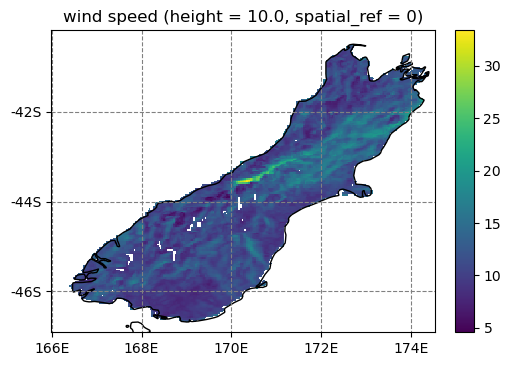

In [38]:
fwi_masked = south_island(land_only_max_wind)
plt.figure(dpi=100)
fwi_masked.salem.quick_map()

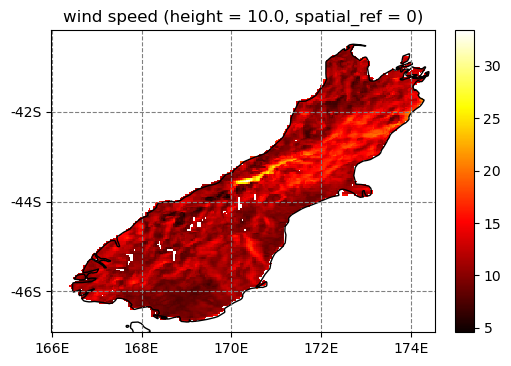

In [16]:
u_file='/mnt/data/MetService_WRF/U_20000101000000.nc'
v_file='/mnt/data/MetService_WRF/V_20000101000000.nc'
t_file = '/mnt/data/MetService_WRF/T_20000101000000.nc'
smois_file = '/mnt/data/MetService_WRF/SMOIS_20000101000000.nc'

chunks={"height":1,"time":100}

def calculate_ws_wd(u,v):
    wspeed = xr.ufuncs.sqrt(u*u + v * v)
    wdir   = (270-xr.ufuncs.arctan2(v,u)* 180/ np.pi)%360
    wspeed.name = "wind speed"
    wdir.name = "wind dir"
    wspeed.attrs["units"] = "m/s"
    return wspeed, wdir

ds_u = xr.open_dataset(u_file,chunks=chunks)
ds_v = xr.open_dataset(v_file,chunks=chunks)
ds_t = xr.open_dataset(t_file,chunks=chunks)
ds_s = xr.open_dataset(smois_file,chunks=chunks)

wind, _ = calculate_ws_wd(ds_u.U,ds_v.V)
land_only_max_wind = mask_land(wind).isel(height=0).max(dim="time")
plt.figure(dpi=100)
land_only_max_wind_sth = south_island(land_only_max_wind)
land_only_max_wind_sth.salem.quick_map(cmap="hot")

The above map shows wind speed for the south island it will be used later when discussing the SOM maps

In [18]:
FWI_5_YEARS

<xarray.Dataset>
Dimensions:  (time: 1828, lat: 508, lon: 472)
Coordinates:
  * time     (time) datetime64[ns] 2015-12-31 2016-01-01 ... 2020-12-31
  * lat      (lat) float64 -48.0 -47.97 -47.94 -47.92 ... -34.06 -34.03 -34.01
  * lon      (lon) float64 166.0 166.0 166.1 166.1 ... 178.9 178.9 179.0 179.0
Data variables:
    FFMC     (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    DMC      (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    DC       (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    ISI      (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    BUI      (time, lat, lon) float64 dask.array<chunksize=(24, 508, 472), meta=np.ndarray>
    FWI      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [55]:
def dataloader_south_island(dataname, chunks={"time":24,"height":1}):
    """
    loads five years data and pre processes them into chunks
    This uses chunking to demonstrate ability as per (1) in marking criteria, 
    It does however seem to make the kernel unstable compared to not using dask mf parellel datasets
    Remove all but south island from dataset, (does not include stewart island)
    """
    five_years = ["2016", "2017", "2018", "2019", "2020"]
    files = [sorted(glob.glob(f"/mnt/data/FWI_WRF/{dataname}{year}*", recursive=False)) for year in five_years]
    merged = list(itertools.chain(*files))
    south = south_island(xr.open_mfdataset(merged, chunks=chunks, parallel=True))
    return mask_land(south)

In [56]:
south_island_df = dataloader_south_island("FWI_")
south_island_df

<xarray.Dataset>
Dimensions:      (time: 1828, lat: 244, lon: 310)
Coordinates:
  * lat          (lat) float64 -46.9 -46.87 -46.84 ... -40.24 -40.22 -40.19
  * lon          (lon) float64 166.0 166.0 166.1 166.1 ... 174.5 174.5 174.5
  * time         (time) datetime64[ns] 2015-12-31 2016-01-01 ... 2020-12-31
    spatial_ref  int64 0
    height       float64 1.0
Data variables:
    FFMC         (time, lat, lon) float64 dask.array<chunksize=(24, 244, 310), meta=np.ndarray>
    DMC          (time, lat, lon) float64 dask.array<chunksize=(24, 244, 310), meta=np.ndarray>
    DC           (time, lat, lon) float64 dask.array<chunksize=(24, 244, 310), meta=np.ndarray>
    ISI          (time, lat, lon) float64 dask.array<chunksize=(24, 244, 310), meta=np.ndarray>
    BUI          (time, lat, lon) float64 dask.array<chunksize=(24, 244, 310), meta=np.ndarray>
    FWI          (time, lat, lon) float64 dask.array<chunksize=(24, 244, 310), meta=np.ndarray>

Below is a quick check my south island data loader works and displays the south island displaying FWI as a heat map (sum of fwi)

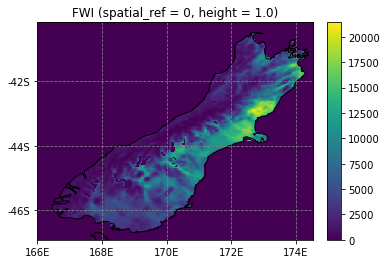

In [57]:
south_island_df.FWI.sum(axis=0).salem.quick_map()

In [63]:
FWI_south_island = south_island_df.FWI
#time = ds.time
ds_np=xr.DataArray.to_numpy(FWI_south_island.load())
ds_np_nonan = np.nan_to_num(ds_np, nan = -9999) # water is all set to this to seperate it

In [64]:
%%time
som, predict_som = calc_som(2,2, ds_np_nonan, epoch=200, rate=0.2)
SOM_SUM_DICT = generate_som_dict(FWI_south_island, predict_som, end=4)
save_som_predictions("FWI_SOUTH_IS_end4_lr2_e20", som)
save_som_pkl("FWI_SOUTH_IS_end4_lr2_e20", predict_som)

CPU times: user 2min 39s, sys: 16.3 s, total: 2min 56s
Wall time: 2min 54s


I tried more epochs, and read a bit more about the sklearn implementation of SOM. Its realy dumbed down and stops when not learning any more, the learning rate adjusts over time to. So its barley worth changing the myou cant really optomize it with the lr and epoch if the size of the data is small like in this problem.

In [66]:
%%time
som, predict_som = calc_som(2,2, ds_np_nonan, epoch=20, rate=0.2)
SOM_SUM_DICT = generate_som_dict(FWI_south_island, predict_som, end=4)
save_som_predictions("FWI_SOUTH_IS_end4_lr2_e20", som)
save_som_pkl("FWI_SOUTH_IS_end4_lr2_e20", predict_som)

CPU times: user 2min 39s, sys: 15.8 s, total: 2min 55s
Wall time: 2min 54s


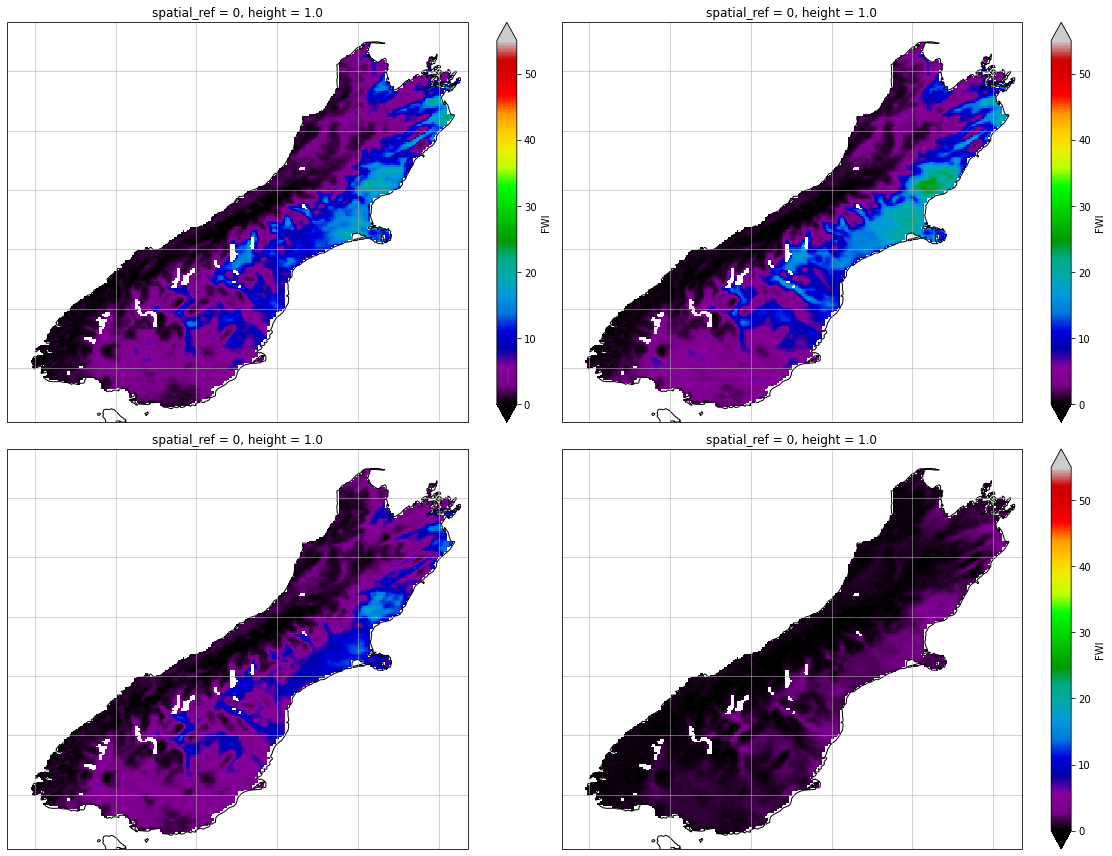

In [65]:
gen_som_maps(FWI_south_island, SOM_SUM_DICT, cmap="nipy_spectral", end=4, vmax=55)

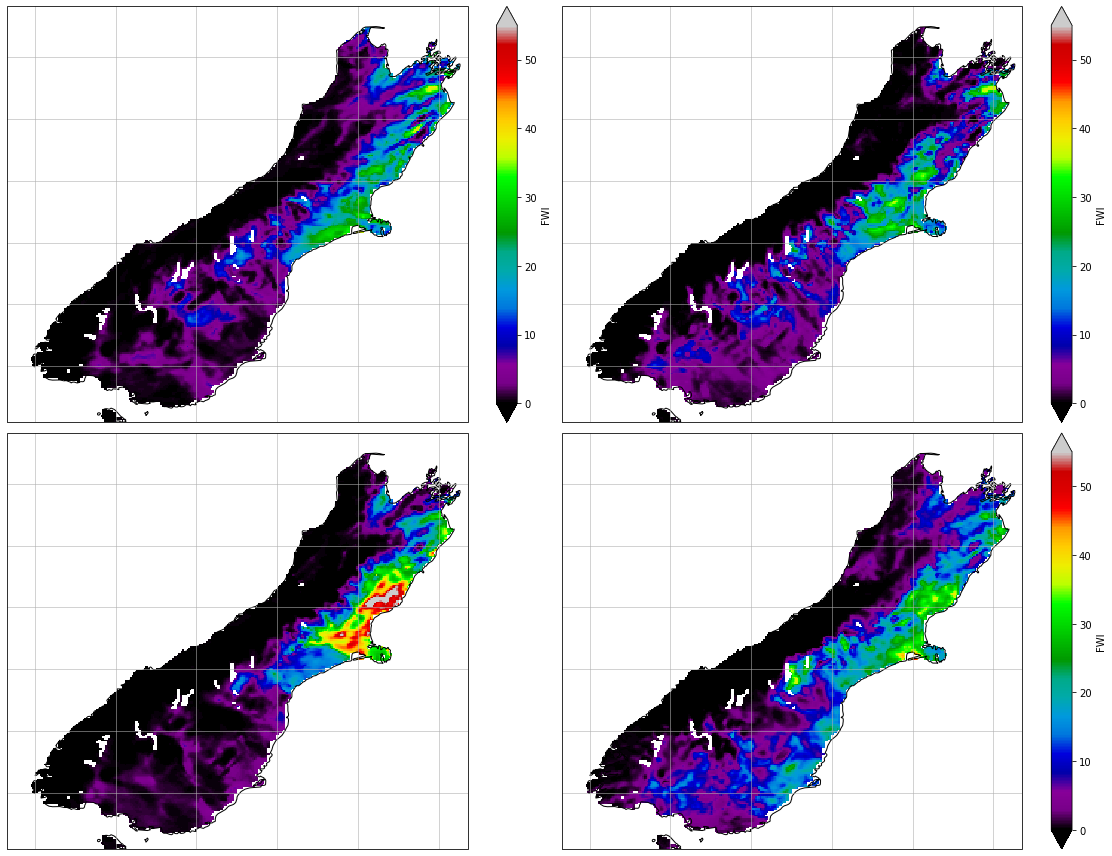

In [60]:
gen_som_maps(FWI_south_island, SOM_SUM_DICT, cmap="nipy_spectral", end=4, vmax=55)

In [67]:
%%time
som, predict_som = calc_som(3,3, ds_np_nonan, epoch=20, rate=0.2)
SOM_SUM_DICT = generate_som_dict(FWI_south_island, predict_som, end=9)
save_som_predictions("FWI_SOUTH_IS_end4_lr2_e20", som)
save_som_pkl("FWI_SOUTH_IS_end4_lr2_e20", predict_som)

CPU times: user 2min 49s, sys: 18.9 s, total: 3min 8s
Wall time: 3min 6s


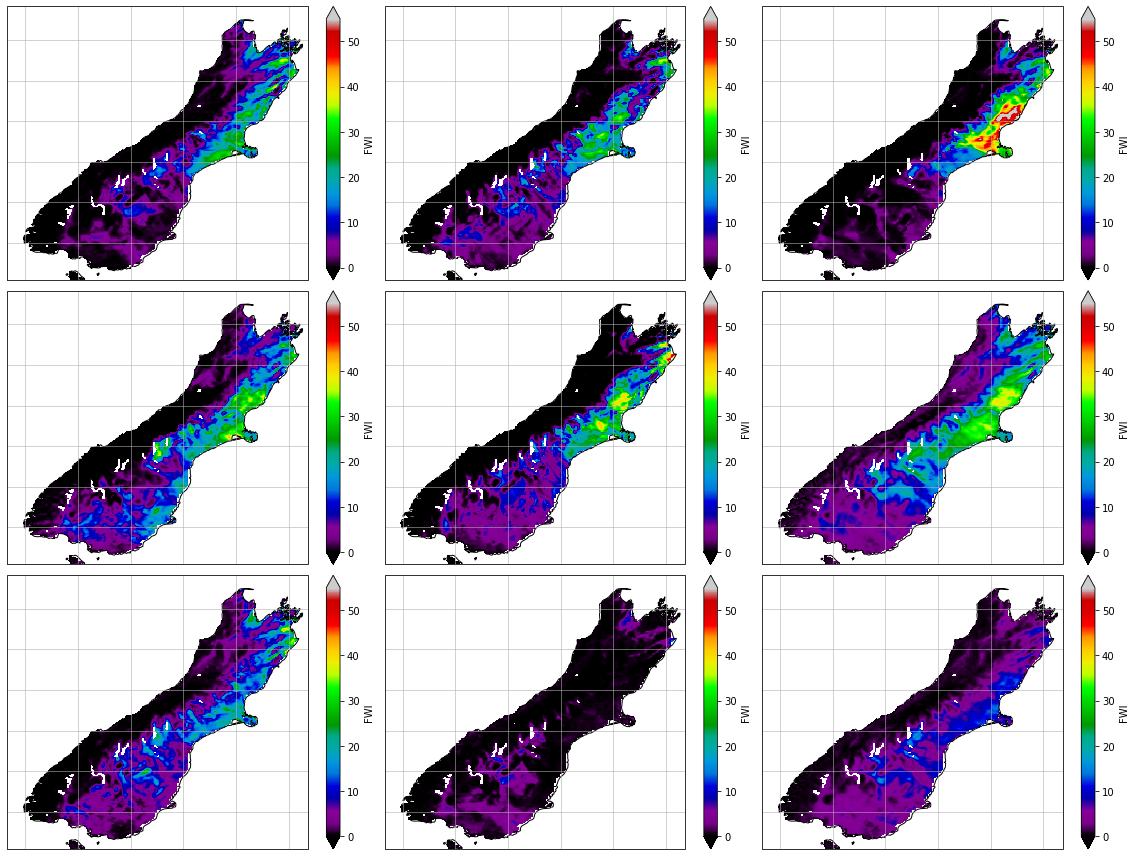

In [62]:
gen_som_maps(FWI_south_island, SOM_SUM_DICT, cmap="nipy_spectral", end=9, vmax=55)

#### The overall areas are if you look at regions are similar to in Q1 as expected. However there is alot more detail in them in this map than in the full country as the SOM buckets can express the vraiance of this smaller area a bit more easily.

#### It is interesing so see the bucket four above and bucket seven show a bit more detail in FWI between 8-14 in otago/dunedien area
#### The eigth bucket is interesting two clumping kaikura and otago as similar

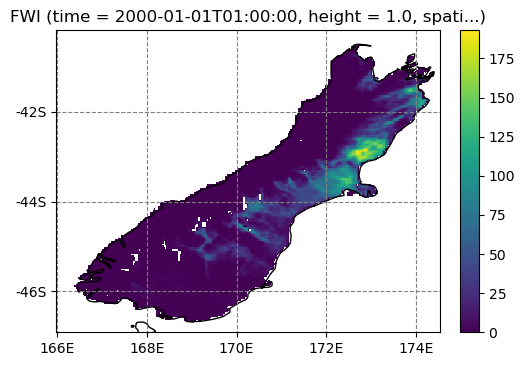

In [69]:
extreme_fwi_days = (FWI_5_YEARS.FWI >= 31).sum(axis=0) # days with at or over 31 in fwi rating
masked = mask_land(extreme_fwi_days)
plt.figure(dpi=100)
masked = south_island(masked)
masked.salem.quick_map()

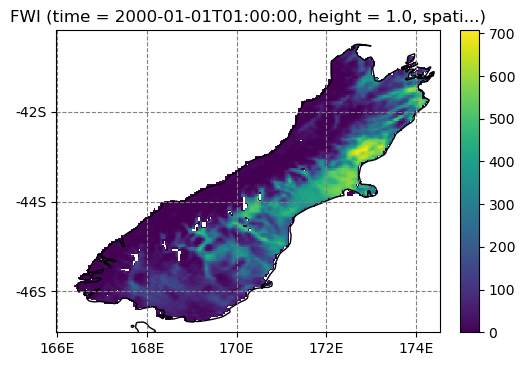

In [71]:
fwi_days = (FWI_5_YEARS.FWI >= 10).sum(axis=0) # days with at or over 31 in fwi rating
masked = mask_land(fwi_days)
plt.figure(dpi=100)
masked = south_island(masked)
masked.salem.quick_map()

#### Above is the areas of high (over 31) and reasonable (over 10) FWI, it is interesting that the 10-14 FWI area in otago can ve seen abit more clearly here. The SOM is vreaking out these FWI brackets into similar buckets

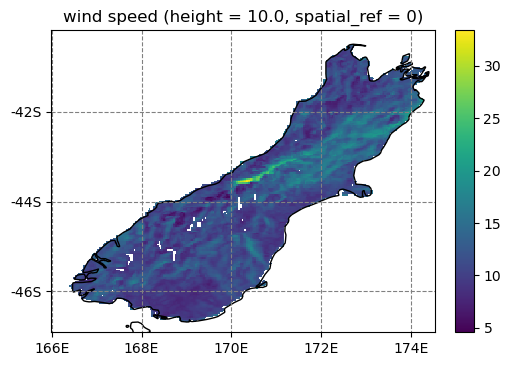

In [74]:
chunks={"height":1,"time":100}
def calculate_ws_wd(u,v):
    wspeed = xr.ufuncs.sqrt(u*u + v * v)
    wdir   = (270-xr.ufuncs.arctan2(v,u)* 180/ np.pi)%360
    wspeed.name = "wind speed"
    wdir.name = "wind dir"
    wspeed.attrs["units"] = "m/s"
    return wspeed, wdir


wind, _ = calculate_ws_wd(ds_u.U,ds_v.V)
land_only_max_wind = mask_land(wind).isel(height=0).max(dim="time")
masked = south_island(land_only_max_wind)
plt.figure(dpi=100)
masked.salem.quick_map()

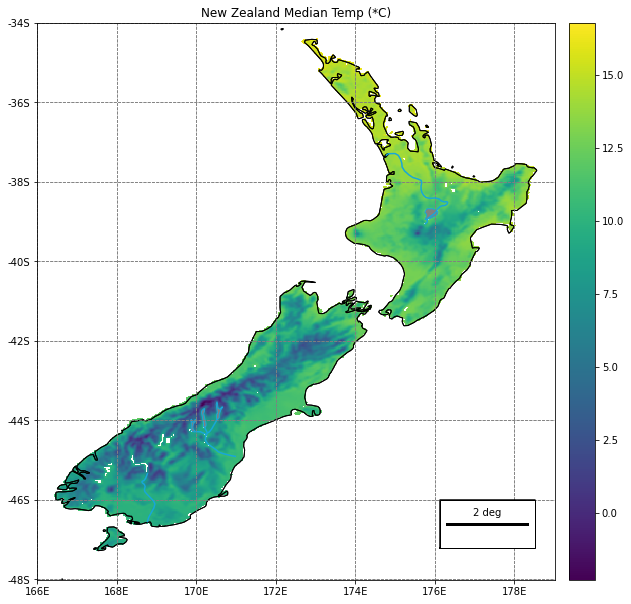

In [243]:
def make_salem(data, title='Temp (*C)'):
    # inspiration taken from https://salem.readthedocs.io/en/v0.2.3/auto_examples/plot_change_style.html#sphx-glr-auto-examples-plot-change-style-py
    # and https://salem.readthedocs.io/en/v0.2.3/auto_examples/plot_subgrid_mask.html
    masked = mask_land(data)
    
    smap = masked.T.salem.get_map(countries=False)
    f, ax = plt.subplots(figsize=(10,40))
    ax2 = masked.T.salem.quick_map()
    # Change the country borders
    smap.set_shapefile(countries=True)
    
    # Add water bodies
    smap.set_shapefile(rivers=True)
    smap.set_shapefile(lakes=True, facecolor='grey')

    smap.set_scale_bar(location=(0.87, 0.1), add_bbox=True)

    #plt.figure(dpi=200)
    smap.visualize(ax=ax, title=f'New Zealand Median {title}')
    plt.show()


make_salem(ds_t_land)

#### The plot above shows the median temperatures for NZ, the lighter areas in the otago reigion likley indicate that warmer temperatures explain how it is getting a cluster for medium-low FWI.
#### The cantervury reigion, kaikura and west coast asre also quire warm. Only Kaikura and more so Canterbury show up with higher FWI clusters however. This can likley be explained with the higer temperature and wind in canterbury with lower rainfall. The west coast does not show up as although it has alot of wind and wamrish weather, it has ALOT of rainfall which lowers the chance of fires and therefore the FWI immensely